In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack

from scipy.interpolate import interp2d

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

### Spergel scarlet fitting errors

In [4]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_5000.fits')[0:2000]

# Modeling using spergel profile
method = 'spergel'
files = [
    f'./Catalog/mock_sample/{method}/_lsbg_meas_{method}_monotonic_{method}_{start}_{start+500}_nosegmap.fits' 
    for start in [0, 500, 1000, 1500]]
meas_cat = vstack([Table.read(file) for file in files])

params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth_0_5000.fits')[0:2000]

print('Total number of objects:', len(obj_cat))

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
print('Incomplete files:', np.sum(bad_flag))
print('Failed modelings:', np.isnan(meas_cat['rhalf_circularized']).sum())
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])
# print('Surface brightness cut:', np.sum(~(params_cat['SB_eff_g'] > 27)))
bad_flag |= (params_cat['SB_eff_g'] > 28)

obj_cat = obj_cat[~bad_flag]
params_cat = params_cat[~bad_flag]
meas_cat = meas_cat[~bad_flag]

print('Number of survived objs afterall:', len(obj_cat))

meas_cat['rhalf_spergel'] = 0.168 * meas_cat['rhalf_spergel']
meas_cat['rhalf_circularized'] = 0.168 * meas_cat['rhalf_circularized']
meas_cat['sersic_rhalf'] = 0.168 * meas_cat['sersic_rhalf']

Total number of objects: 2000
Incomplete files: 28
Failed modelings: 0
Number of survived objs afterall: 1752


In [8]:
re_meas = meas_cat['rhalf_spergel'].data
re_truth =  params_cat['rhalf_circularized'].data

print(np.mean(re_meas - re_truth), np.std(re_meas - re_truth))

SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

ell_truth = params_cat['ellip'].data
ell_meas = meas_cat['ell_sym'].data

gi_truth = params_cat['g-i'].data
gi_meas = (meas_cat['mag'][:, 0] - meas_cat['mag'][:, 2]).data

g_meas = meas_cat['mag'][:, 0].data
g_truth = params_cat['mag_g'].data

spergel_nu = meas_cat['spergel_nu'].data

-0.616372319464243 1.2408208371898848


In [9]:
def predict_bias(y, X, degree=2, hidden_layer_sizes=(64, 64, 64), random_state=None):
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.neural_network import MLPRegressor
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    if random_state is None:
        random_state = 1
    # Polynomial features
    pipeline = make_pipeline(PolynomialFeatures(degree), StandardScaler())
    X_poly = pipeline.fit_transform(X)
    
    X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, 
                                                                  test_size=0.3, 
                                                                  random_state=random_state)
    
    # NN regressor
    regr = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                        random_state=random_state, 
                        max_iter=500
                       ).fit(X_train_poly, y_train)
    print('Score:', regr.score(X_test_poly, y_test))
    pipeline2 = make_pipeline(pipeline, regr)
    return pipeline2

In [10]:
X = np.vstack([re_meas, SB_meas, gi_meas, spergel_nu]).T
y = re_truth
ppl = predict_bias(y, X)
re_truth_pred = ppl.predict(X)

Score: 0.9481476720650474


In [11]:
np.median(re_truth_pred - y)

-0.05695198563392623

(2.0, 15.0)

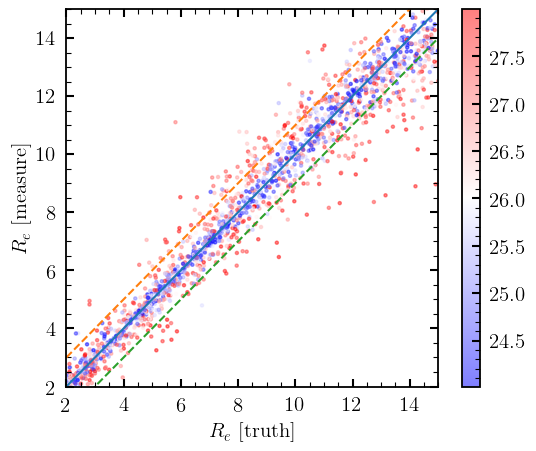

In [12]:
plt.scatter(re_truth, re_truth_pred, 
            c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

In [13]:
from scipy.stats import binned_statistic_dd

In [40]:
y = re_truth - re_truth_pred # re_truth - re_meas #
X = np.vstack([re_meas, SB_meas]).T


n_bins = [10, 10]
min_num = 10
_range = [[1, 15], [23, 30]]
_extent = [item for sublist in _range for item in sublist]

ret = binned_statistic_dd(X, y, statistic='median', bins=n_bins, 
                          range=_range, expand_binnumbers=True)

ret_std = binned_statistic_dd(X, y, statistic='std', bins=n_bins, 
                              range=_range)

ret_cnt = binned_statistic_dd(X, y, statistic='count', bins=n_bins, 
                              range=_range, 
                              binned_statistic_result=ret_std)

flag = (ret_cnt.statistic < min_num)
ret.statistic[flag] = np.nan
ret_std.statistic[flag] = np.nan

ret.statistic[:np.digitize(23.4, ret.bin_edges[1]), 
              :np.digitize(5, ret.bin_edges[0])] = np.nan
ret_std.statistic[:np.digitize(23.4, ret.bin_edges[1]), 
                  :np.digitize(5, ret.bin_edges[0])] = np.nan

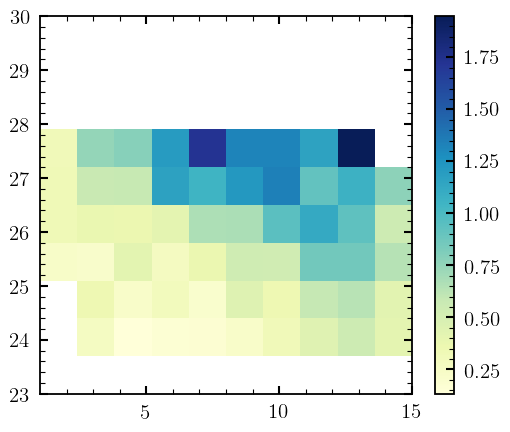

In [41]:
# plt.scatter(re_meas, SB_meas)
plt.imshow(ret_std.statistic.T, 
#            vmin=-1, vmax=1, 
           origin='lower',
           cmap='YlGnBu', 
           extent=_extent, 
           aspect='auto')
plt.colorbar()

In [42]:
def get_edge_cens(edges):
    return [0.5 * (_edge[:-1] + _edge[1:]) for _edge in edges]

In [43]:
x1, x2 = np.meshgrid(*get_edge_cens(ret.bin_edges))
X = np.vstack([x1.ravel(), x2.ravel()]).T

y = ret_std.statistic.T
Y = y.ravel()
flag = ~np.isnan(y)

x1 = x1[flag]
x2 = x2[flag]
y = y[flag]
#### y = np.nan_to_num(ret_std.statistic, nan=4)

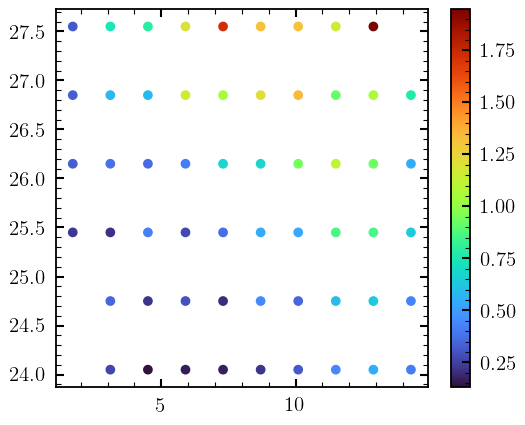

In [44]:
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.colorbar()

In [45]:
from astropy.modeling import models, fitting
p_init = models.Chebyshev2D(x_degree=2, y_degree=2)
# p_init = models.Polynomial2D(degree=2)
fit_p = fitting.LevMarLSQFitter()
p = fit_p(p_init, x1.ravel(), x2.ravel(), y.ravel())

Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff} (g)$ [mag arcsec$^{-2}$]')

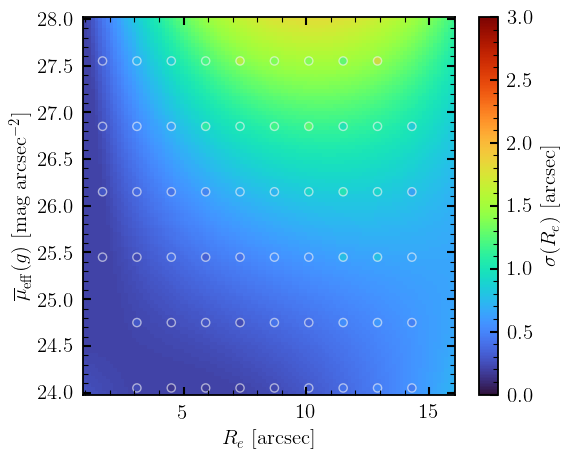

In [46]:
x1_test, x2_test = np.meshgrid(np.linspace(1, 16, 100), np.linspace(24, 28, 100))
C = p(x1_test, x2_test)
C[C < 0.2] = 0.2
plt.pcolormesh(x1_test, x2_test, C, vmin=0, vmax=3)
plt.colorbar(label=r'$\sigma(R_e)$ [arcsec]')

plt.scatter(X[:, 0], X[:, 1], c=Y, s=35, vmin=0, vmax=3, edgecolors='whitesmoke', alpha=0.6)

plt.xlabel(r'$R_e$ [arcsec]')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

In [47]:
p(2, 29)

0.7654398754841978

In [48]:
sigma_re = p(re_meas, SB_meas)

(2.0, 15.0)

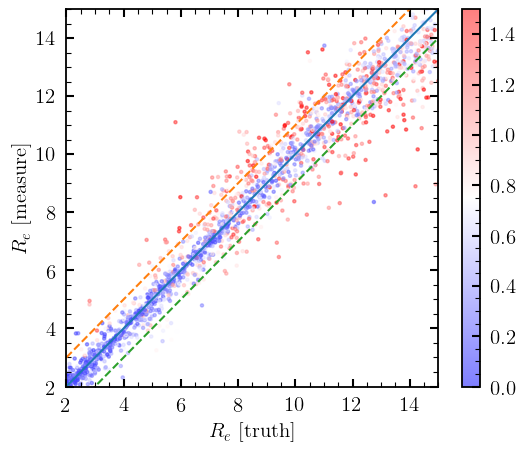

In [49]:
plt.scatter(re_truth, re_truth_pred, 
            c=sigma_re, 
            cmap='bwr',
            vmin=0, vmax=1.5,
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

-0.8935975031647286 1.674226660370951


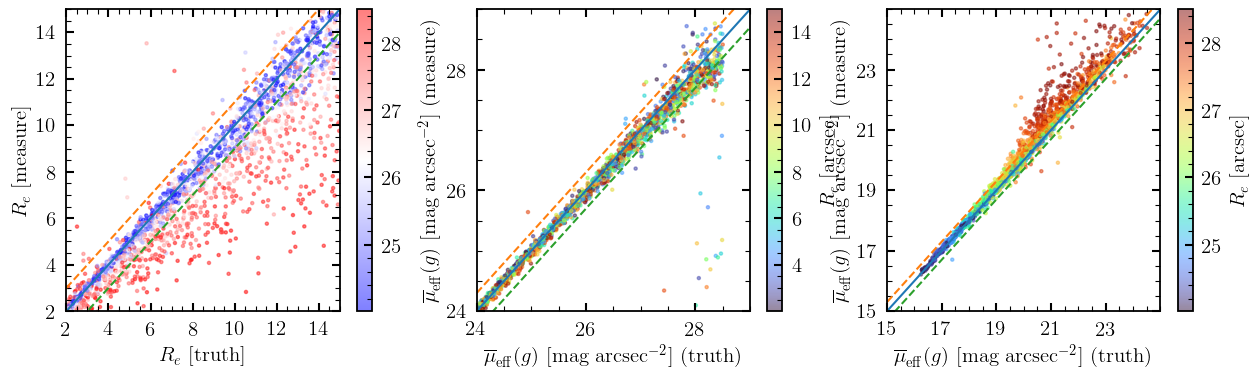

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

re_meas = meas_cat['rhalf_spergel'].data
re_truth =  params_cat['rhalf_circularized'].data

print(np.mean(re_meas - re_truth), np.std(re_meas - re_truth))

SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

# compare R_e
plt.sca(axes[0])
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

# compare SB_eff
plt.sca(axes[1])
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)


# Compare total magnitude
plt.sca(axes[2])
mag_meas = meas_cat['mag'].data[:, 0]
mag_truth = params_cat['mag_g'].data

plt.scatter(mag_truth, mag_meas, c=SB_truth, s=5, alpha=0.5)
x = np.linspace(15, 25, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar(label=r'$R_e$ [arcsec]')
plt.xticks(ticks=np.arange(15, 25, 2))
plt.yticks(ticks=np.arange(15, 25, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(15, 25)
plt.ylim(15, 25)

plt.subplots_adjust(wspace=0.2)